In [4]:
## first softmax version
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
# Cell 1: Import the module
from gp_softmax_torch_works_play import *
## first softmax version
%load_ext autoreload
%autoreload 2
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Generate synthetic data
N = 100  # Number of individuals
D = 5    # Number of diseases
T = 50   # Number of time points
K = 3    # Number of topics
P = 5    # Number of genetic covariates
torch.manual_seed(42)
np.random.seed(42)
# 1. Generate synthetic data with true parameters
true_data = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)
Y = true_data['Y']
G = true_data['G']
prevalence = true_data['prevalence']
event_times = true_data['event_times']
true_pi = true_data['pi']

# Initialize the model
model = AladynSurvivalModel(N, D, T, K, P, G, Y, prevalence)



Epoch 0
Loss: 9654.4219
Length scales: [16.665667 16.665667 16.665667]
Amplitudes: [1.0010005 1.0010005 1.0010005]
Max gradients - λ: 60.8843, φ: 53.6663, γ: 32.0120
Mean condition number: 9847.14

Epoch 10
Loss: 5213.6924
Length scales: [16.655586 16.655584 16.6556  ]
Amplitudes: [1.0111578 1.0111588 1.0111569]
Max gradients - λ: 29.9919, φ: 25.5484, γ: 29.0627
Mean condition number: 5022.13

Epoch 20
Loss: 4495.6006
Length scales: [16.64509  16.645077 16.64518 ]
Amplitudes: [1.0219766 1.0219882 1.0219712]
Max gradients - λ: 28.6632, φ: 24.2326, γ: 25.9653
Mean condition number: 5127.98

Epoch 30
Loss: 3942.3599
Length scales: [16.634504 16.634455 16.634691]
Amplitudes: [1.0331136 1.0331483 1.0331106]
Max gradients - λ: 27.1253, φ: 22.8149, γ: 23.7106
Mean condition number: 5238.13

Epoch 40
Loss: 3515.3660
Length scales: [16.623919 16.62381  16.6242  ]
Amplitudes: [1.0444679 1.0445423 1.0444846]
Max gradients - λ: 25.4919, φ: 21.3383, γ: 21.3820
Mean condition number: 5351.97

Epoch

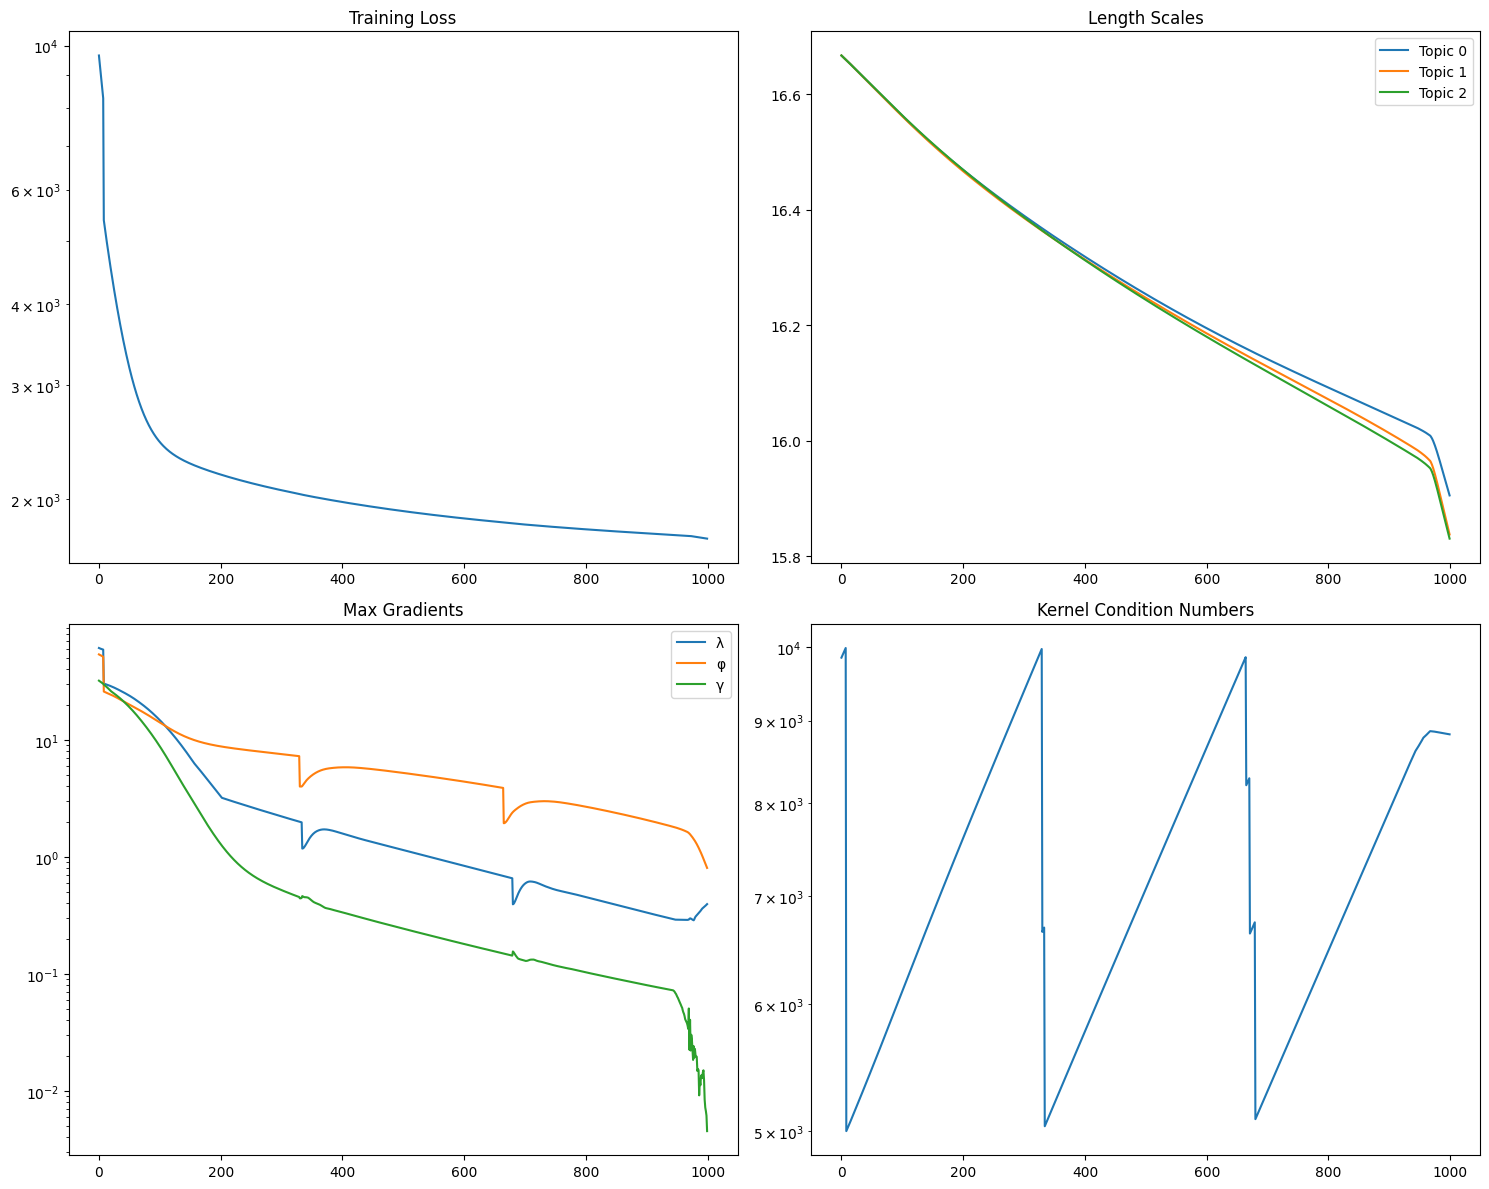

In [8]:

# Fit the model
num_epochs = 100
learning_rate = 1e-3
lambda_reg = 1e-2  # L2 regularization weight for gamma

history = model.fit(event_times, num_epochs=1000)
plot_training_diagnostics(history)




In [9]:

# 4. Get model predictions
pi_pred, theta_pred, phi_pred = model.forward()



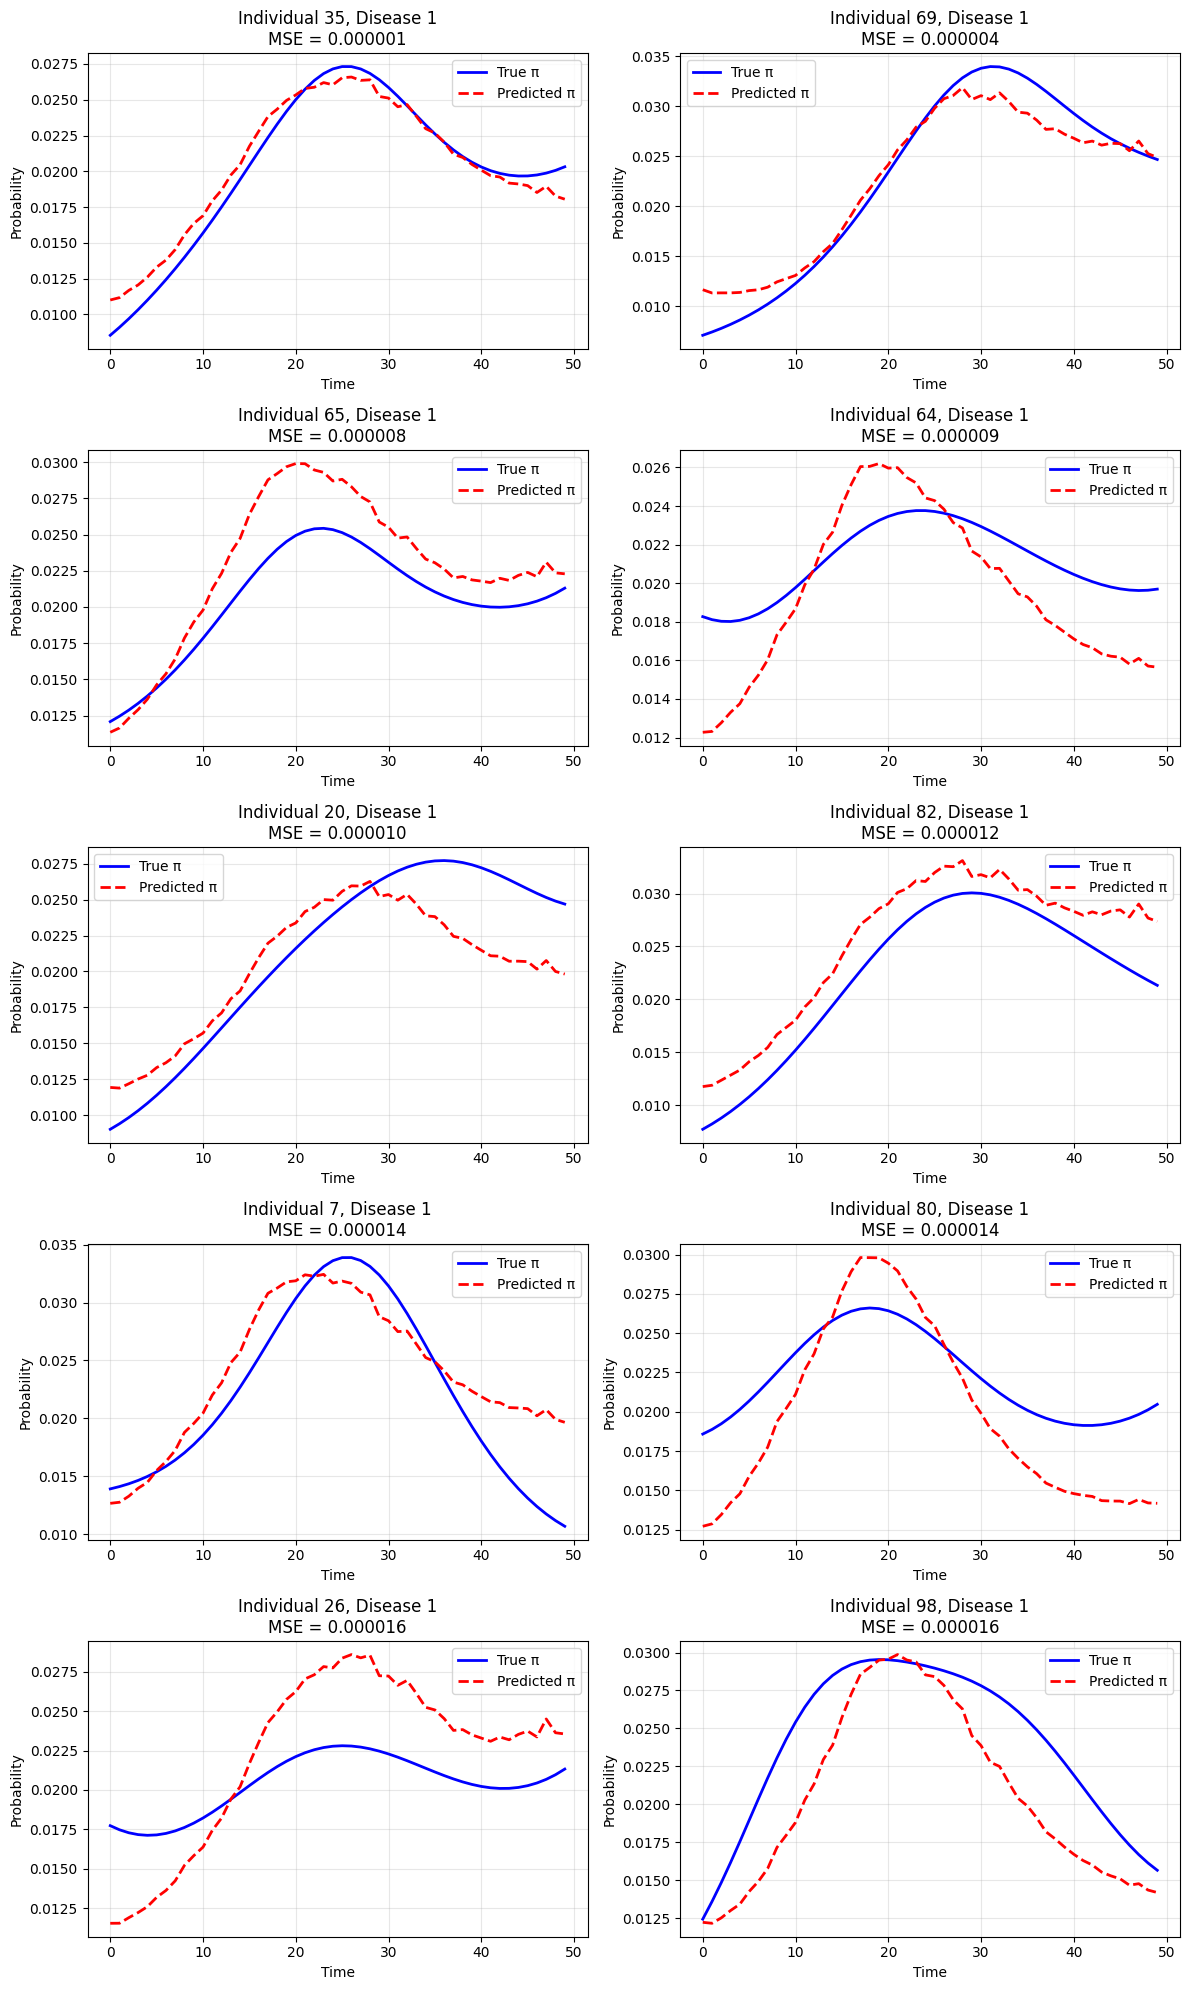

In [10]:

pi_pred, theta_pred, phi_pred = model.forward()
plot_best_matches(true_pi, pi_pred, n_samples=10, n_cols=2)


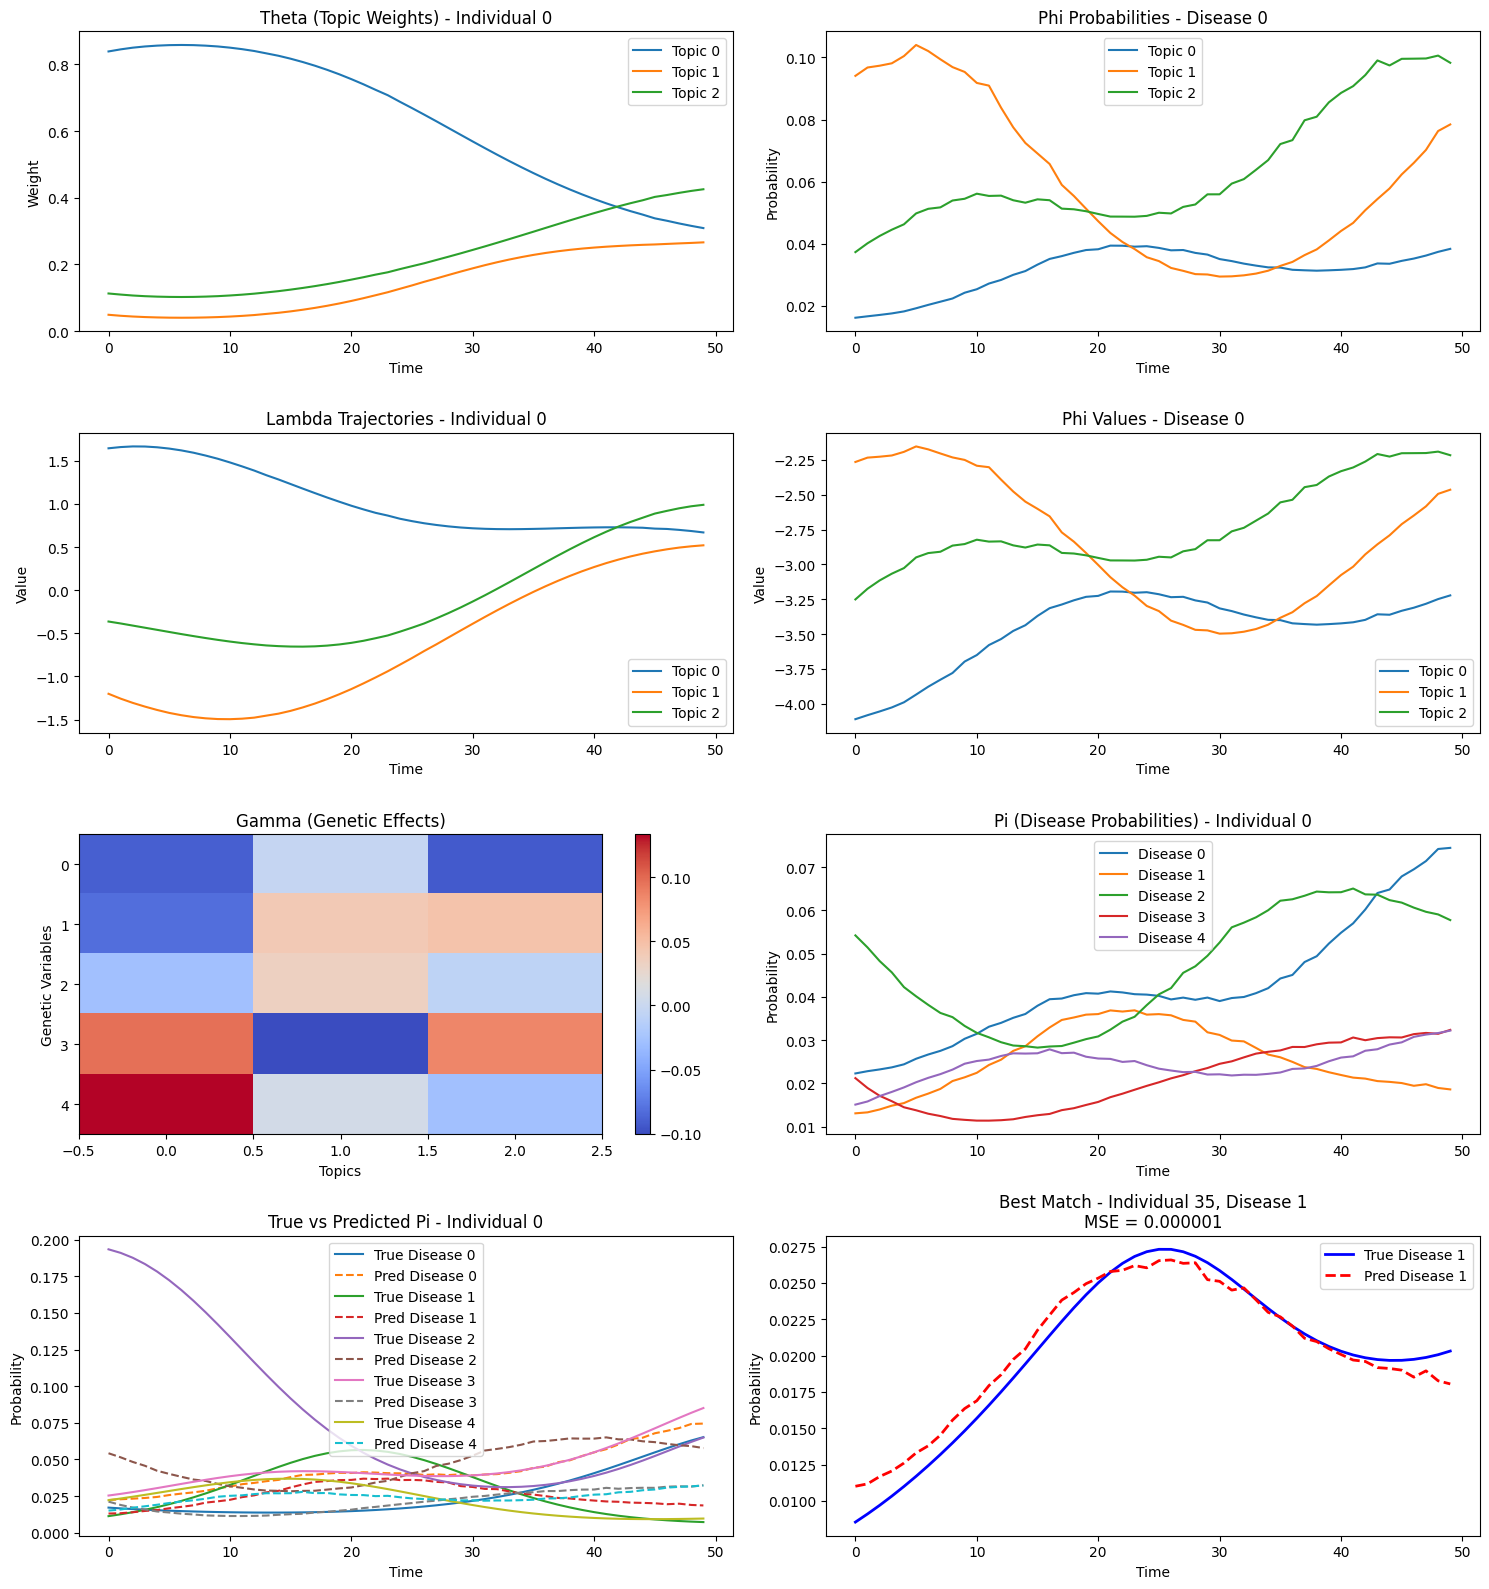

In [11]:
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(4, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()

for d in range(D):
    axes[3, 0].plot(true_pi[0, d, :], '-', label=f'True Disease {d}')
    axes[3, 0].plot(pi_pred_np[0, d, :], '--', label=f'Pred Disease {d}')
axes[3, 0].set_title('True vs Predicted Pi - Individual 0')
axes[3, 0].set_xlabel('Time')
axes[3, 0].set_ylabel('Probability')
axes[3, 0].legend()

# 8. Plot true vs predicted pi for a good match
# Find a good matching individual-disease pair
mse = np.mean((true_pi - pi_pred_np)**2, axis=2)  # N×D
best_idx = np.unravel_index(np.argmin(mse), mse.shape)
i_best, d_best = best_idx

axes[3, 1].plot(true_pi[i_best, d_best, :], 'b-', 
                label=f'True Disease {d_best}', linewidth=2)
axes[3, 1].plot(pi_pred_np[i_best, d_best, :], 'r--', 
                label=f'Pred Disease {d_best}', linewidth=2)
axes[3, 1].set_title(f'Best Match - Individual {i_best}, Disease {d_best}\nMSE = {mse[i_best, d_best]:.6f}')
axes[3, 1].set_xlabel('Time')
axes[3, 1].set_ylabel('Probability')
axes[3, 1].legend()

plt.tight_layout()
plt.show()



In [12]:
def plot_all_pi_comparison(true_pi, pred_pi):
    """
    Plot all predicted vs true pi values
    
    Parameters:
    true_pi: numpy array (N×D×T)
    pred_pi: torch tensor (N×D×T)
    """
    # Convert to numpy and flatten
    pred_pi_np = pred_pi.detach().numpy()
    true_flat = true_pi.flatten()
    pred_flat = pred_pi_np.flatten()
    
    # Create plot
    plt.figure(figsize=(10, 10))
    
    # Scatter plot
    plt.scatter(true_flat, pred_flat, alpha=0.1, color='blue')
    
    # Add diagonal line
    max_val = max(true_flat.max(), pred_flat.max())
    min_val = min(true_flat.min(), pred_flat.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
    
    # Add correlation coefficient
    corr = np.corrcoef(true_flat, pred_flat)[0,1]
    mse = np.mean((true_flat - pred_flat)**2)
    
    plt.title(f'True vs Predicted π\nR: {corr:.3f}, MSE: {mse:.6f}')
    plt.xlabel('True π')
    plt.ylabel('Predicted π')
    plt.legend()
    
    # Make plot square
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()



Epoch 0
Loss: 9902.3096
Length scales: [16.665667 16.665667 16.665667]
Amplitudes: [1.0010005 1.0010005 1.0010005]
Max gradients - λ: 69.7086, φ: 63.8296, γ: 22.2800
Mean condition number: 9847.14

Epoch 10
Loss: 5429.6226
Length scales: [16.655588 16.655588 16.655588]
Amplitudes: [1.0111587 1.011157  1.0111579]
Max gradients - λ: 32.7938, φ: 30.2310, γ: 22.8457
Mean condition number: 5022.16

Epoch 20
Loss: 4705.1704
Length scales: [16.645103 16.645103 16.645103]
Amplitudes: [1.0219835 1.0219665 1.0219743]
Max gradients - λ: 30.7617, φ: 28.5205, γ: 21.3807
Mean condition number: 5127.78

Epoch 30
Loss: 4147.6304
Length scales: [16.634521 16.634508 16.634525]
Amplitudes: [1.0331362 1.0330931 1.0331092]
Max gradients - λ: 28.7885, φ: 26.8856, γ: 19.8590
Mean condition number: 5238.06

Epoch 40
Loss: 3717.4756
Length scales: [16.623917 16.623886 16.623953]
Amplitudes: [1.0445203 1.0444419 1.0444621]
Max gradients - λ: 26.7500, φ: 25.2462, γ: 18.2880
Mean condition number: 5351.73

Epoch

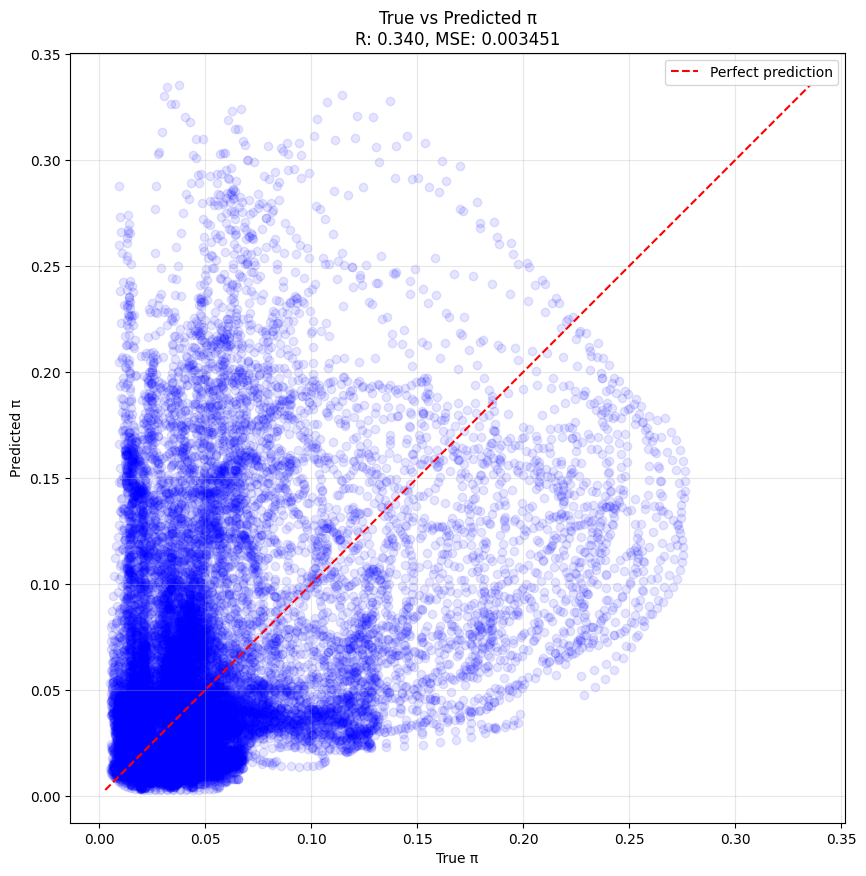

In [15]:
# Generate synthetic data
N = 100  # Number of individuals
D = 5    # Number of diseases
T = 50   # Number of time points
K = 3    # Number of topics
P = 5    # Number of genetic covariates


true_data = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)
Y = true_data['Y']
G = true_data['G']
prevalence = true_data['prevalence']
event_times = true_data['event_times']
true_pi = true_data['pi']

# 2. Initialize model
model = AladynSurvivalModel(N, D, T, K, P, G, Y, prevalence)

# 3. Fit model
losses = model.fit(event_times, num_epochs=100)

# 4. Get model predictions
pi_pred, theta_pred, phi_pred = model.forward()

plot_all_pi_comparison(true_pi, pi_pred)
